In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
time_step = 30
input_num = 200
adjust_steps = 200

tau_i_input = 2 * np.ones(input_num)
tau_i_output = 2
tau_u = 5

i_input_decay = (1-1/tau_i_input)
i_output_decay = (1-1/tau_i_output)
u_decay = (1-1/tau_u)

In [2]:
def smooth(x, decay):
    if len(x.shape)==1:
        x = x.reshape(1,len(x))
    x = x.astype(float)
    x_smooth = np.zeros_like(x)
    x_smooth[:,0]=x[:,0]/(1/(1-decay))
    for i in range(len(x[0])-1):
        x_smooth[:,i+1] = x_smooth[:,i]*decay + x[:,i+1].astype(float)/(1/(1-decay))
    return x_smooth

In [3]:
def sigmoid(x,temp):
    exp = np.clip(-x/temp, -10, 10)
    return 1 / (1 + np.exp(exp))

In [4]:
output_record = np.zeros((adjust_steps, time_step))
delta_0_record = np.zeros((adjust_steps, time_step))
delta_record = np.zeros((adjust_steps, time_step))
grad_record = np.zeros((adjust_steps, time_step))

loss_record = np.zeros(adjust_steps)
tau_u_record = np.zeros(adjust_steps)
i_decay_record = np.zeros(adjust_steps)
u = np.zeros(time_step)
delta_u = np.zeros(time_step)
output = np.zeros(time_step)

In [5]:
def gen_partial_a(delta):
    partial_a = np.zeros((time_step, time_step))
    for t in range(time_step):
        if t > 0:
            partial_a[t] = partial_a[t - 1] - partial_a[t - 1] / tau_i_output
        partial_a[t, t] = 1/tau_i_output
    for t in range(time_step):
        if delta[t] <= 0:
#             partial_a[t-1, t] = -1
#             for j in range(t-2,-1,-1):
#                 partial_a[j,t] = partial_a[j+1,t] * (1 - 1 / tau_i_output)
            partial_a[t, t] = 0
        else:
            partial_a[t, t] = -1
    return partial_a
    
partial_a_0 = np.zeros((time_step, time_step))
for t in range(time_step):
    if t > 0:
        partial_a_0[t] = partial_a_0[t - 1] - partial_a_0[t - 1] / tau_i_output
    partial_a_0[t, t] = 1/tau_i_output



In [6]:
def figs_plot(plot_flag):
    if plot_flag:
        plt.figure()
        plt.plot(loss_record)
        
        plt.figure(figsize=(12,5*adjust_steps/time_step/2))

        plt.subplot(131)
        plt.imshow(output_record, cmap='cividis')
        plt.title('output record')
        for i,o in enumerate(desired_output[0]):
            if o == 1:
                plt.plot((i,i),(0,adjust_steps-1),c='r',alpha=1)
        plt.colorbar()
    #     plt.figure(figsize=(5,5*adjust_steps/time_step))

    #     plt.figure(figsize=(5,5*adjust_steps/time_step))
        plt.subplot(132)
        plt.imshow(delta_record, cmap='cividis')
        plt.title('delta_record')
        for i,o in enumerate(desired_output[0]):
            if o == 1:
                plt.plot((i,i),(0,adjust_steps-1),c='r',alpha=1)
        plt.colorbar()
                
        plt.subplot(133)
        plt.imshow(grad_record, cmap='cividis')
        plt.title('grad_record')
        for i,o in enumerate(desired_output[0]):
            if o == 1:
                plt.plot((i,i),(0,adjust_steps-1),c='r',alpha=1)
        plt.colorbar()
def prepare_plot(plot_flag):
    if plot_flag:
        plt.figure(figsize=(6,4))
        global u_fig
        u_fig = plt.axes()
        plt.title("Membrane Potential")
        
        plt.figure(figsize=(6,4))
        global delta_u_fig
        delta_u_fig = plt.axes()
        plt.title('delta_u')
        
        plt.figure(figsize=(6,4))
        global delta_fig
        delta_fig = plt.axes()
        plt.title('Delta')

        plt.figure(figsize=(6,4))
        global grad_fig
        grad_fig = plt.axes()
        plt.title('Grad')
        


In [7]:
threshold = 1
temp = 2

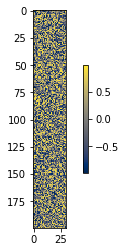

In [8]:
from scipy import stats

a = np.random.randint(0,20, size=(input_num,time_step))
a = (a==0).astype(float)
a_smooth = smooth(a, i_input_decay)
a_smooth = stats.zscore(a_smooth)
a_smooth = np.random.uniform(-1,1,size=(input_num,time_step))
plt.figure(figsize=(6,4))
plt.imshow(a_smooth, cmap='cividis')
plt.colorbar(shrink=.5)

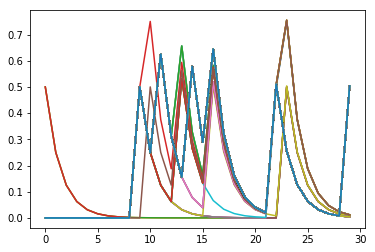

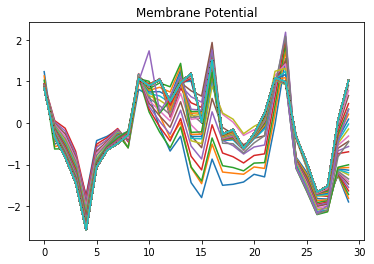

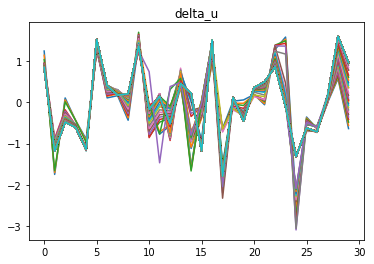

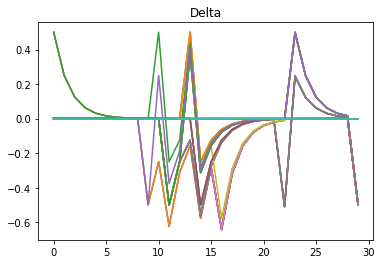

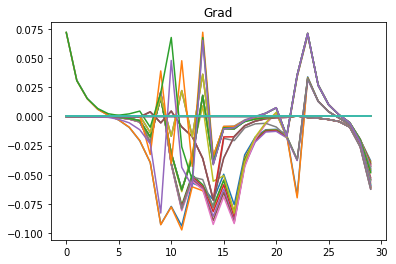

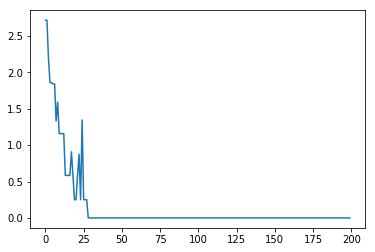

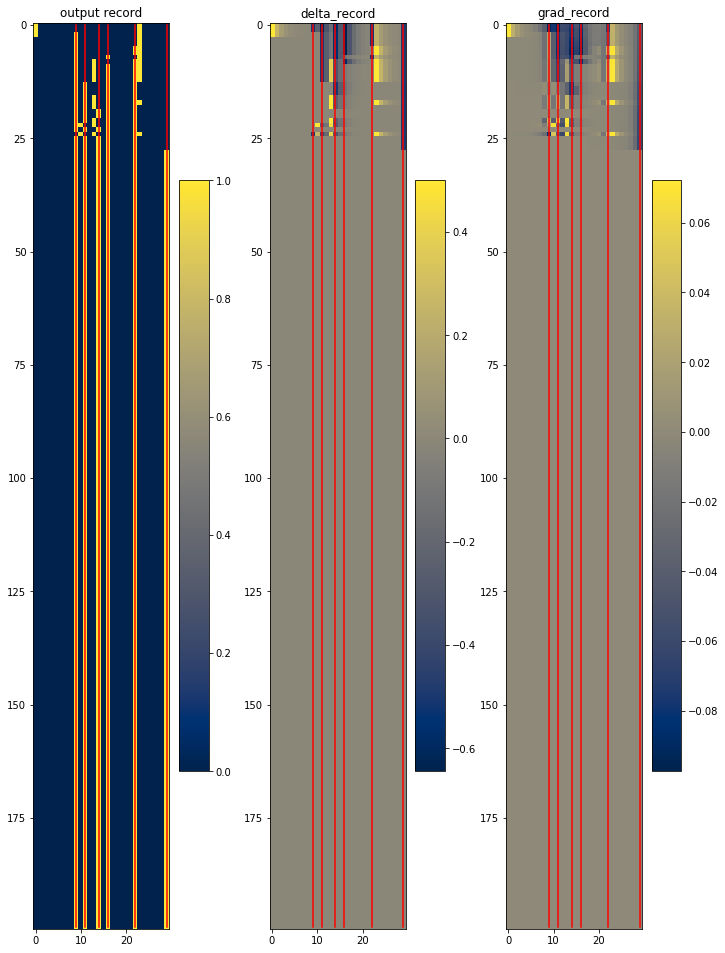

In [52]:
weights = (np.random.normal(size=input_num)) *0.1
desired_output = np.random.randint(0,4,size=(1,time_step))
desired_output = (desired_output == 0).astype(float)
plt.figure()
output_fig = plt.axes()
desired_output_smooth = smooth(desired_output, i_output_decay)
output_fig.plot(desired_output_smooth[0])

# If plot needed, set plot_flag = True
plot_flag = True
prepare_plot(plot_flag)

# tau_i_input = 2 * np.ones(input_num)
# tau_i_output = 2
# tau_u = 5

# i_input_decay = (1-1/tau_i_input)
# i_output_decay = (1-1/tau_i_output)
# u_decay = (1-1/tau_u)
lr = 0.02
for i in range(adjust_steps):
    lr *= 0.996
    # Forward
    output = np.zeros(time_step)
    u[0] = delta_u[0] = u_temp = np.dot(weights, a_smooth[:,0])
    
    if u[0] > threshold:
        u_temp = 0
        output[0] = 1
    for j in range(time_step-1):
        u[j+1] = u_temp * u_decay + np.dot(weights,a_smooth[:,j+1])
        delta_u[j+1] = u[j+1] - u[j]
        if u[j+1] > threshold:
            u_temp = 0
            output[j+1] = 1
        else:
            u_temp = u[j+1]
    output_smooth = smooth(output, i_output_decay)
    output_fig.plot(output_smooth[0])
    
    # Record status
    output_record[i] = output
#     output_smooth_record[i] = output_smooth
#     u_record[i] = u
    
    # Backward
    # Calculate weight's gradient
    delta = (output_smooth-desired_output_smooth)[0]
    delta_record[i] = delta
     
    loss_record[i] = np.sum((output_smooth-desired_output_smooth)[0]**2)
    # Find neighbors
    PSC_delta = np.zeros(time_step)
    project = np.zeros(time_step)
    for t in range(time_step):
        neighbor_output = output > 0
        near_by = True
        current_t = t
        while near_by == True:
            neighbor_output[current_t] = neighbor_output[current_t] ^ near_by
            current_t += 1
            if current_t == time_step:
                break
            # New output of the previous time step
            nopp = neighbor_output[current_t - 1]
            # Membrane potential of the current time step
            mbp = u[current_t]
            near_by = near_by&\
                ((near_by&(nopp==True)&((threshold<=mbp)&(mbp<(threshold+u_decay))))|\
                (near_by&(nopp==False)&(((threshold-u_decay)<mbp)&(mbp<threshold))))
        neighbor_PSC = smooth(neighbor_output.astype('float'), i_output_decay)
        PSC_delta = neighbor_PSC - output_smooth
        project[t] = PSC_delta.dot(-delta)/np.linalg.norm(PSC_delta)

    sig = sigmoid(u-threshold, temp)
    grad = project * (output - 0.5) * 2 * (sig*(1-sig))/temp

    grad_w = grad.dot(a_smooth.T)
    
    grad_record[i] = grad

    if plot_flag:
        u_fig.plot(u)
        delta_u_fig.plot(delta_u)
        delta_fig.plot(delta)
        grad_fig.plot(grad)
    
    # Move Step
    weights = weights - lr * grad_w
figs_plot(plot_flag)

In [55]:
import torch
a = torch.tensor([-0.0001,0.0001,-1,1])
a.where(a)

tensor([ 1.0000e-06, -1.0000e-06,  1.0000e-06, -1.0000e-06])

In [58]:
0.98**300

0.002332505667951413

In [63]:
for i in range(9,10):
    print(i)

9
